Deleting model components (O_z).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Deleting model components (O_z).
Deleting model components (source).
Deleting model components (destination).
Deleting model components (intermediate).
    (type=<class 'pyomo.core.base.constraint.ScalarConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.AbstractScalarConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Deleting model components (O_z).
Deleting model components (source).

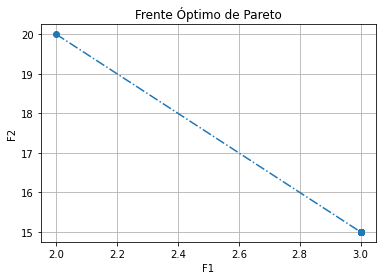

In [1]:
"""
Script que calcula el Frente de Pareto (metodo de e-constraint) de dos funciones objetivo del modelo matematico.

@author: Gabriel Beltran & Andres Triana
"""


##############################################################################
#####################        LIBRERÍAS        ################################
##############################################################################

#Plot Imports
import matplotlib.pyplot as plt

#Pyomo Imports (Modelo Matematico)
from pyomo.environ import *
from pyomo.opt import SolverFactory

##############################################################################
#####################        FUNCIONES        ################################
##############################################################################

#FUNCION ELIMINAR COMPONENTE
def delete_component(Model, comp_name):

        list_del = [vr for vr in vars(Model)
                    if comp_name == vr
                    or vr.startswith(comp_name + '_index')
                    or vr.startswith(comp_name + '_domain')]

        list_del_str = ', '.join(list_del)
        print('Deleting model components ({}).'.format(list_del_str))

        for kk in list_del:
            Model.del_component(kk)
##############################################################################
#####################        MODELO           ################################
##############################################################################

#Configuración Iteraciones----------------------------------------------------
numIteraciones=11 
iteraciones=range(numIteraciones)
e_vec=[2,3,4,5,6,7,8,9,10,11]

       

    
#Creación Modelo--------------------------------------------------------------
Model = ConcreteModel()

#sets & parameters------------------------------------------------------------
numNodes = 5
Model.N=RangeSet(1,numNodes)

#hops-----------------------------------------------------------------------
Model.h =Param(Model.N, Model.N, mutable=True)

for i in Model.N:
    for j in Model.N:
        Model.h[i,j] = 999


Model.h[1,2] = 1
Model.h[1,3] = 1
Model.h[2,5] = 1
Model.h[3,4] = 1
Model.h[4,5] = 1

#costos-----------------------------------------------------------------------
Model.c =Param(Model.N, Model.N, mutable=True)

for i in Model.N:
    for j in Model.N:
        Model.c[i,j] = 999

Model.c[1,2] = 10
Model.c[1,3] = 5
Model.c[2,5] = 10
Model.c[3,4] = 5
Model.c[4,5] = 5

#origen y destino-----------------------------------------------------------------------
        
s = 1
d = 5
        

#variables--------------------------------------------------------------------
            
#Variable binaria que indica si el enlace (i,j) es seleccionado para hacer parte 
#del camino que va del nodo fuente al nodo destino.
Model.x = Var(Model.N,Model.N, domain=Binary)


## OBJECTIVE FUNCTIONS*************************************************************

#Función hops
Model.f1 = sum(Model.x[i,j] * Model.h[i,j] for i in Model.N for j in Model.N)

#Función de costos
Model.f2 = sum(Model.x[i,j] * Model.c[i,j] for i in Model.N for j in Model.N)


#Proceso para ejecutar varias veces el modelo matemático con el fin de aplicar el
#método de e-constraint.
cont=-1
f1_vec=[]
f2_vec=[]
for k in e_vec:
    cont=cont+1
    e=e_vec[cont]
    #Función objetivo general
    Model.O_z = Objective(expr=Model.f2, sense=minimize)
    
    #e-constraint
    Model.f1_constraint = Constraint(expr= Model.f1 <= e)

    ##Restricción nodo origen
    def source_rule(Model,i):
        if i==s:
            return sum(Model.x[i,j] for j in Model.N)==1
        else:
            return Constraint.Skip

    Model.source=Constraint(Model.N, rule=source_rule)
        
    #Restricción nodo destino
    def destination_rule(Model,j):
        if j==d:
            return sum(Model.x[i,j] for i in Model.N)==1
        else:
            return Constraint.Skip

    Model.destination=Constraint(Model.N, rule=destination_rule)
    
    #Restricción nodo intermedio
    def intermediate_rule(Model,i):
        if i!=s and i!=d:
            return sum(Model.x[i,j] for j in Model.N) - sum(Model.x[j,i] for j in Model.N)==0
        else:
            return Constraint.Skip

    Model.intermediate=Constraint(Model.N, rule=intermediate_rule)
    
    SolverFactory('glpk').solve(Model)
    
    valorF1=value(Model.f1)
    valorF2=value(Model.f2)
    f1_vec.append(valorF1)
    f2_vec.append(valorF2)
    
    delete_component(Model, 'O_z')
    delete_component(Model, 'source')
    delete_component(Model, 'destination')
    delete_component(Model, 'intermediate')
    
    #end for

plt.plot(f1_vec,f2_vec,'o-.')
plt.title('Frente Óptimo de Pareto')
plt.xlabel('F1')
plt.ylabel('F2')

plt.grid(True)
plt.show()
